In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import tracemalloc

 In this question you will implement and compare the following different KNN variantsNN


Vary dataset size $N$, number of dimensions $D$ to do training and testing time and memory comparison for finding $K$ nearest neighbours.

In [2]:
class naive_version:
    def __init__(self):
        self.data=None
        self.query=None
        self.k=None
        self.distances=[]
        
    def fit(self,x,k):
        self.data=x
        self.k=k
        
    def compute_distances(self):
        distances=np.zeros(len(self.data))
        for i in range(len(self.data)):
            distances[i]=np.linalg.norm(self.data[i]-self.query)
        return distances    

    def predict(self,y):
        self.query=y
        self.distances=self.compute_distances()
        nearest_indices=np.argsort(self.distances)[:self.k]        
        return self.data[nearest_indices]

In [3]:
class lsh_version:
    def __init__(self):
        self.data=None
        self.query=None
        self.k=None
        self.hashed_data=None
        self.hashingvectors=[]

    def compute_distances(self):
        distances=np.zeros(len(self.hashed_data))
        for i in range(len(self.hashed_data)):
            distances[i]=np.linalg.norm(self.hashed_data[i]-self.query)
        return distances

    def fit(self,x,k):
        self.data=x
        self.k=k
        nplanes=int(np.log(len(self.data)//(k*2))/np.log(2))
        self.hashingvectors=np.random.randn(nplanes,x.shape[1])

    def predict(self,y):
        self.query=y
        planetest_data=(self.data@self.hashingvectors.T)>=0
        planetest_query=(self.query@self.hashingvectors.T)>=0
        hashed_plane=np.where((planetest_data==planetest_query).all(axis=1))[0]
        self.hashed_data=self.data[hashed_plane]
        distances=self.compute_distances()
        nearest_indices=np.argsort(distances)[:self.k]
        return self.hashed_data[nearest_indices]

In [4]:
class node:
    def __init__(self,point):
        self.point=point
        self.left=None
        self.right=None

class kdtree_version:
    def __init__(self):
        self.data=None
        self.query=None
        self.k=None
        self.hashed_data=None
        
    def fit(self,x,k):
        self.data=x
        self.hashed_data=self.data
        self.k=k
        self.root=self.create_decision_boundaries(self.data,0)

    def create_decision_boundaries(self,dataset,axis):
        if (len(dataset)<=self.k*3):
            return None
        axis=axis%dataset.shape[1]
        medianvector=np.zeros((1,dataset.shape[1]))
        median=np.median(dataset[:,axis])
        medianvector[0][axis]=median
        currentnode=node(medianvector[0])
        currentnode.left=self.create_decision_boundaries(dataset[dataset[:,axis]<median],axis+1)
        currentnode.right=self.create_decision_boundaries(dataset[dataset[:,axis]>=median],axis+1)
        return currentnode
        
    def predict(self,y):
        self.query=y;
        self.hashing(self.root,0)
        distances=self.compute_distances()
        nearest_indices=np.argsort(distances)[:self.k]
        return self.hashed_data[nearest_indices]
        
    def hashing(self,node,axis):
        if node is None:
            return
        axis=axis%node.point.shape[0]
        if (node.point[axis]>self.query[0][axis]):
            self.hashed_data=self.hashed_data[self.hashed_data[:,axis]<node.point[axis]]
        else:
            self.hashed_data=self.hashed_data[self.hashed_data[:,axis]>=node.point[axis]]
        self.hashing(node.left,axis+1)
        self.hashing(node.right,axis+1)
        return
        
    def compute_distances(self):
        distances=np.zeros(len(self.hashed_data))
        for i in range(len(self.hashed_data)):
            distances[i]=np.linalg.norm(self.hashed_data[i]-self.query)
        return distances
            

In [5]:
N_list=np.array([100,500,1000])
D_list=np.array([10,20,30])

def N_comparison(N_values,D):
    timetraining_dict={
        'Naive':[],
        'LSH':[],
        'KDTree':[]    
    }

    timetesting_dict={
        'Naive':[],
        'LSH':[],
        'KDTree':[] 
    }

    mem_dict={
        'Naive':[],
        'LSH':[],
        'KDTree':[]
    }

    def compute_time_memory(model,data_point,query,k):
        tracemalloc.start()
        snapshot_before=tracemalloc.take_snapshot()
        t1=time.time()
        net=model()
        net.fit(data_point,k)
        t2=time.time()
        output=net.predict(query)
        t3=time.time()
        snapshot_after=tracemalloc.take_snapshot()
        top_stats=snapshot_after.compare_to(snapshot_before,'lineno')
        memory=sum(stat.size for stat in top_stats)
        tracemalloc.stop()
        return (t2-t1),(t3-t2),memory/(1024*1024)
        
    
    for N in N_values:
        X_train=np.random.randn(N,D)
        X_test=np.random.randn(1,D)

        t1,t2,memory=compute_time_memory(naive_version,X_train,X_test,10)
        timetraining_dict['Naive'].append(t1)
        timetesting_dict['Naive'].append(t2)
        mem_dict['Naive'].append(memory)
    
        t1,t2,memory=compute_time_memory(lsh_version,X_train,X_test,10)    
        timetraining_dict['LSH'].append(t1)
        timetesting_dict['LSH'].append(t2)        
        mem_dict['LSH'].append(memory)

        t1,t2,memory=compute_time_memory(kdtree_version,X_train,X_test,10)
        timetraining_dict['KDTree'].append(t1)
        timetesting_dict['KDTree'].append(t2)   
        mem_dict['KDTree'].append(memory)

    return timetraining_dict,timetesting_dict,mem_dict

def dim_comparison(N,dim_values):
    timetraining_dict={
        'Naive':[],
        'LSH':[],
        'KDTree':[]    
    }

    timetesting_dict={
        'Naive':[],
        'LSH':[],
        'KDTree':[] 
    }

    mem_dict={
        'Naive':[],
        'LSH':[],
        'KDTree':[]
    }

    def compute_time_memory(model,data_point,query,k):
        tracemalloc.start()
        snapshot_before=tracemalloc.take_snapshot()
        t1=time.time()
        net=model()
        net.fit(data_point,k)
        t2=time.time()
        output=net.predict(query)
        t3=time.time()
        snapshot_after=tracemalloc.take_snapshot()
        top_stats=snapshot_after.compare_to(snapshot_before,'lineno')
        memory=sum(stat.size for stat in top_stats)
        tracemalloc.stop()
        return (t2-t1),(t3-t2),memory/(1024*1024)

    for D in dim_values:
        X_train=np.random.randn(N,D)
        X_test=np.random.randn(1,D)

        t1,t2,memory=compute_time_memory(naive_version,X_train,X_test,10)
        timetraining_dict['Naive'].append(t1)
        timetesting_dict['Naive'].append(t2)
        mem_dict['Naive'].append(memory)
    
        t1,t2,memory=compute_time_memory(lsh_version,X_train,X_test,10)    
        timetraining_dict['LSH'].append(t1)
        timetesting_dict['LSH'].append(t2)        
        mem_dict['LSH'].append(memory)

        t1,t2,memory=compute_time_memory(kdtree_version,X_train,X_test,10)
        timetraining_dict['KDTree'].append(t1)
        timetesting_dict['KDTree'].append(t2)   
        mem_dict['KDTree'].append(memory)
        
    return timetraining_dict,timetesting_dict,mem_dict

In [6]:
def plot_timecomparison(ax,timetable,D,xlabel,title):
    timetable.plot(kind='bar',ax=ax)

    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel('Time (seconds)',fontsize=12)
    ax.set_title(title,fontsize=14)
    
    ax.grid(True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    ax.legend(title="Models",loc='upper left')

def plot_memorycomparison(ax,memorytable,N,xlabel,title):
    memorytable.plot(kind='bar',ax=ax)

    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel('Memory (MB)',fontsize=12)
    ax.set_title(title,fontsize=14)

    ax.grid(True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    ax.legend(title="Models",loc='upper left')

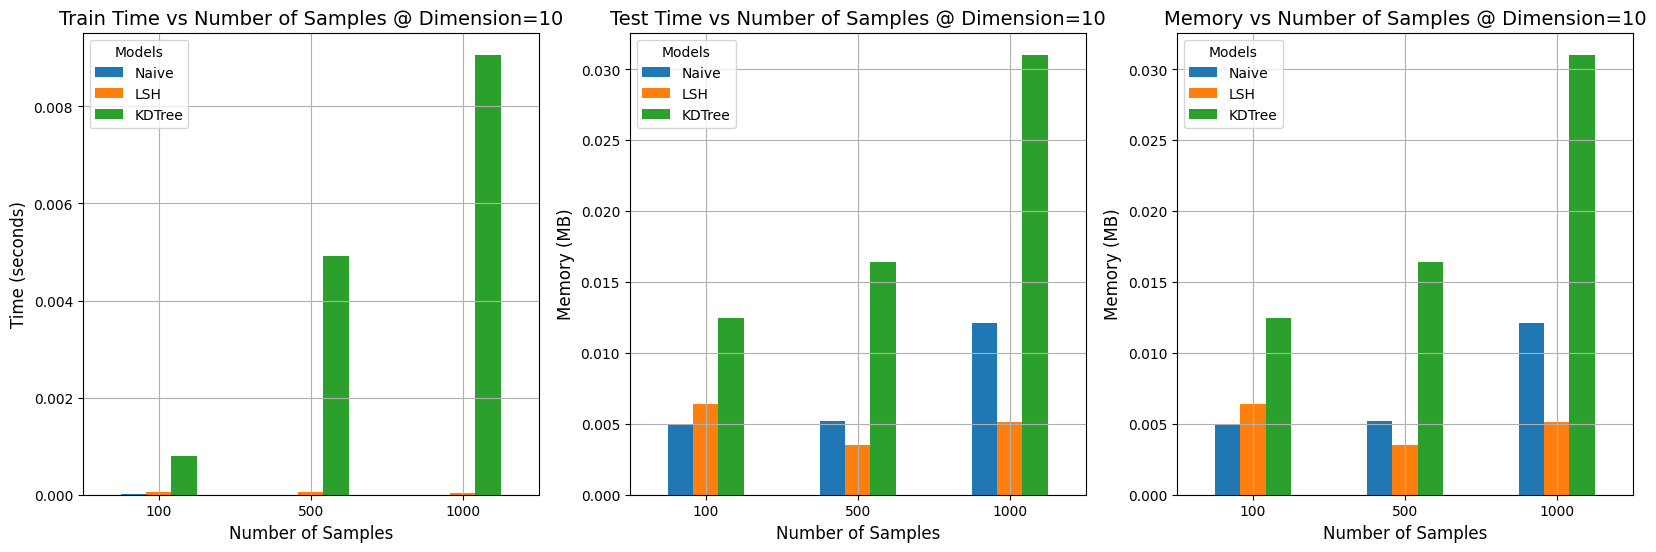

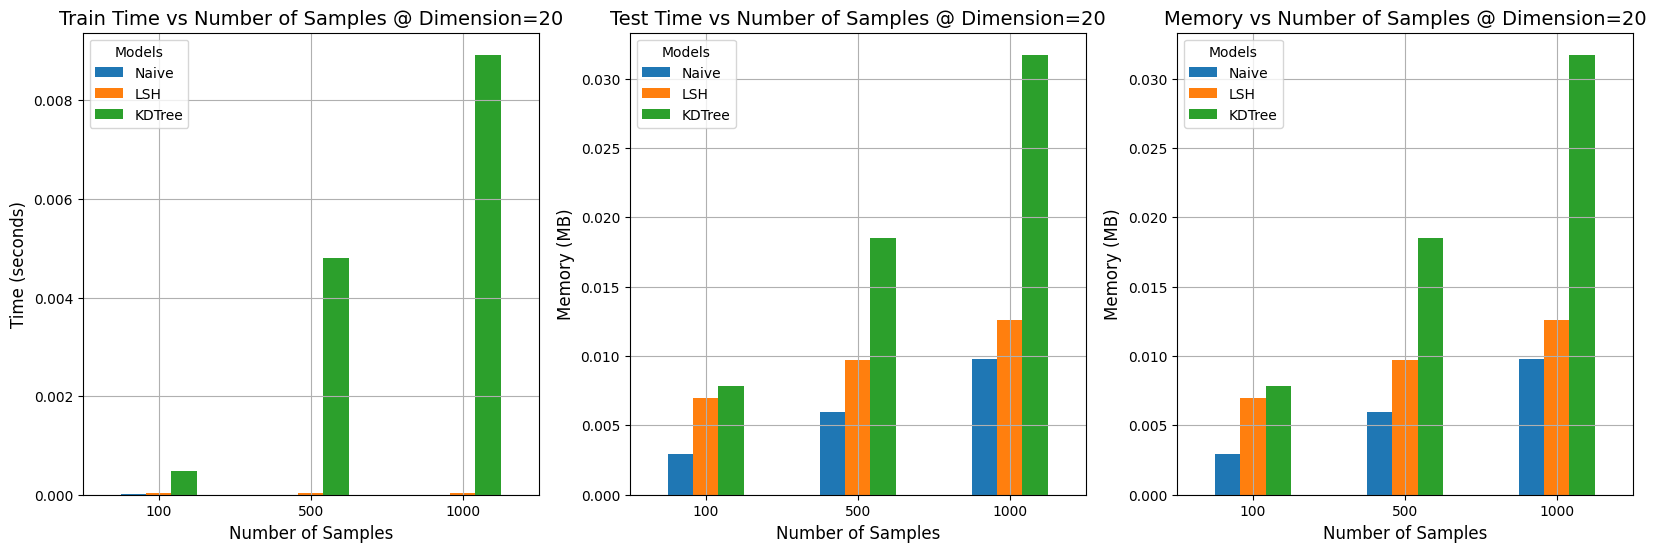

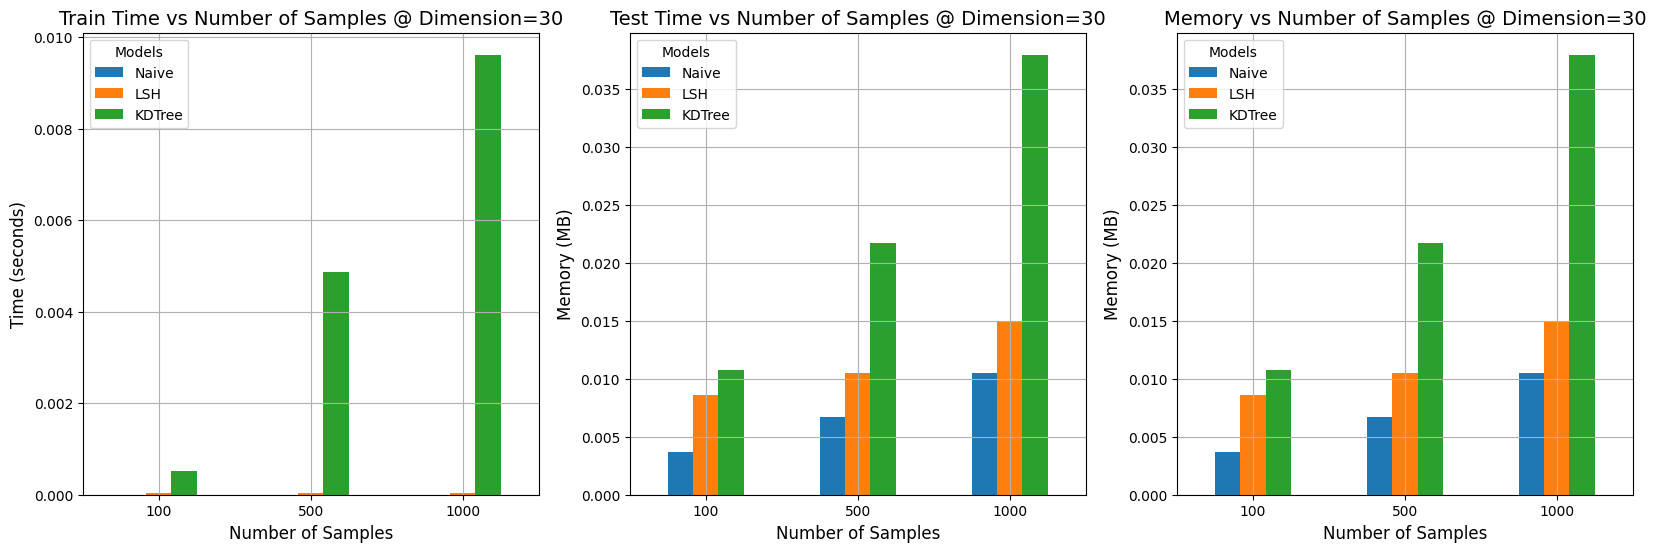

In [7]:
for i in range(len(D_list)):
    fig=plt.figure(figsize=(20,6))
    ax1=fig.add_subplot(131)
    ax2=fig.add_subplot(132)
    ax3=fig.add_subplot(133)
    
    timetrain_table,timetest_table,memory_table=N_comparison(N_list,D_list[i])
    timetrain_table=pd.DataFrame(timetrain_table,index=N_list)
    memory_table=pd.DataFrame(memory_table,index=N_list)
    timetest_table=pd.DataFrame(timetest_table,index=N_list)
    plot_timecomparison(ax1,timetrain_table,D_list[i],'Number of Samples',f'Train Time vs Number of Samples @ Dimension={D_list[i]}')
    plot_memorycomparison(ax2,memory_table,D_list[i],'Number of Samples',f'Test Time vs Number of Samples @ Dimension={D_list[i]}')
    plot_memorycomparison(ax3,memory_table,D_list[i],'Number of Samples',f'Memory vs Number of Samples @ Dimension={D_list[i]}')

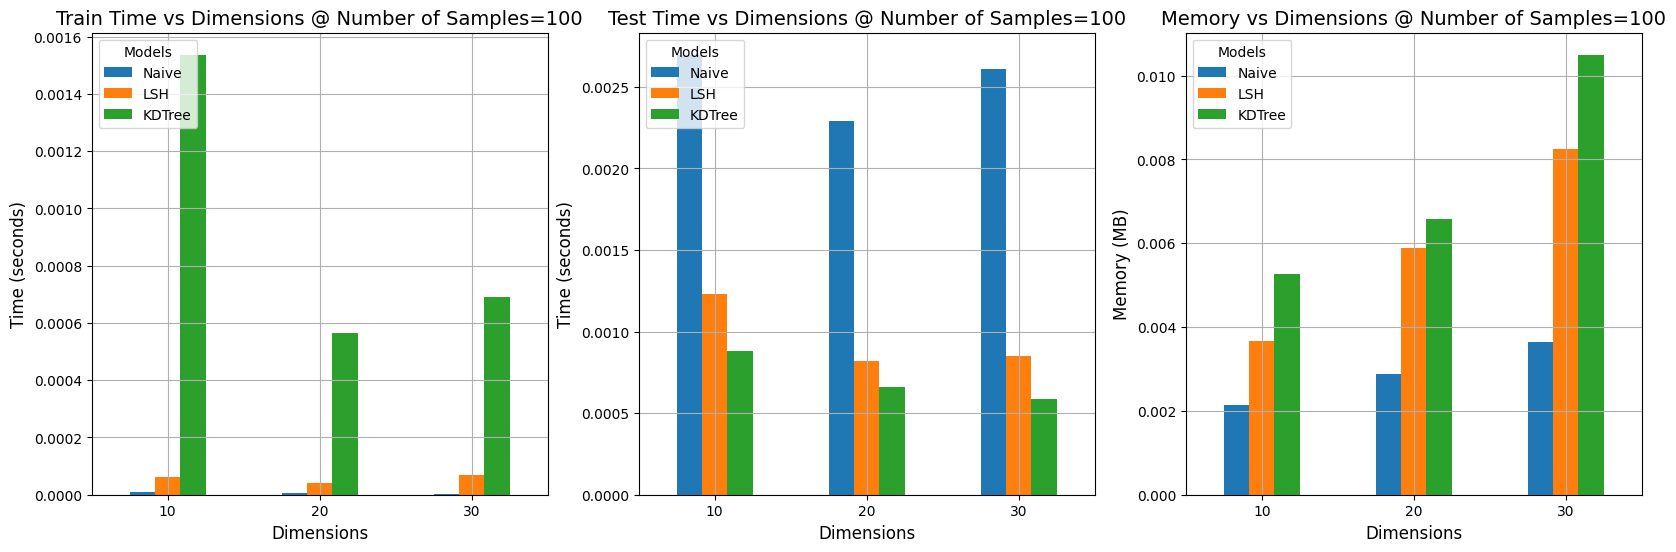

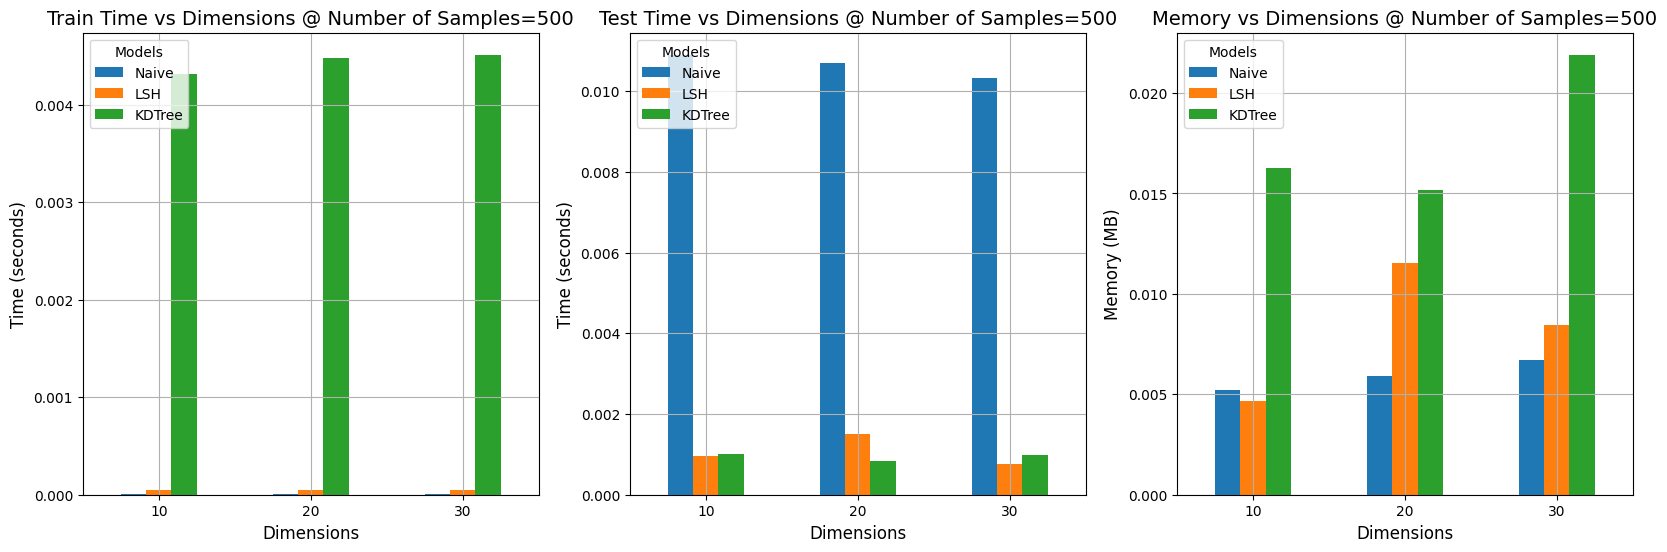

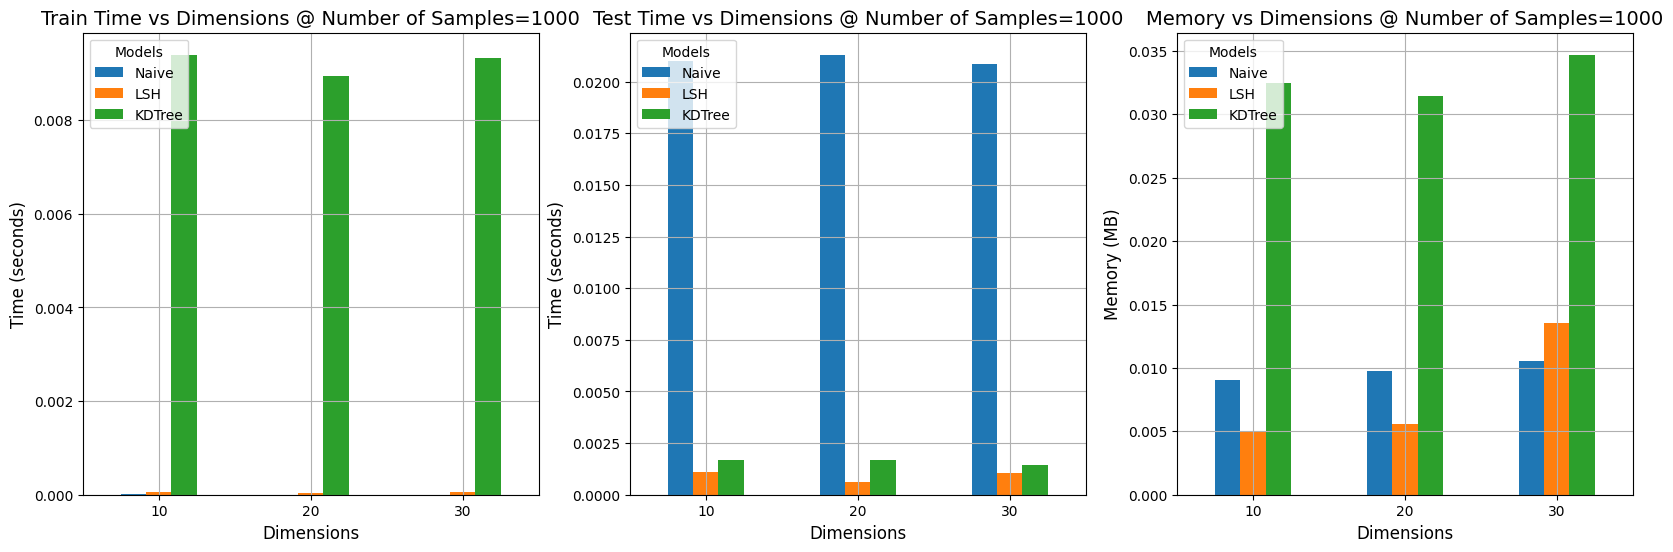

In [8]:
for i in range(len(N_list)):
    fig=plt.figure(figsize=(20,6))
    ax1=fig.add_subplot(131)
    ax2=fig.add_subplot(132)
    ax3=fig.add_subplot(133)
    
    timetrain_table,timetest_table,memory_table=dim_comparison(N_list[i],D_list)
    timetrain_table=pd.DataFrame(timetrain_table,index=D_list)
    timetest_table=pd.DataFrame(timetest_table,index=D_list)
    memory_table=pd.DataFrame(memory_table,index=D_list)
    plot_timecomparison(ax1,timetrain_table,N_list[i],'Dimensions',f'Train Time vs Dimensions @ Number of Samples={N_list[i]}')
    plot_timecomparison(ax2,timetest_table,N_list[i],'Dimensions',f'Test Time vs Dimensions @ Number of Samples={N_list[i]}')
    plot_memorycomparison(ax3,memory_table,N_list[i],'Dimensions',f'Memory vs Dimensions @ Number of Samples={N_list[i]}')

 In a 2d randomly generated dataset visually show how many of the $K$ closest neighbors appx. $K$ NN methods miss out due to their approximate nature.


In [30]:
X_train=np.random.randn(75,2)
X_test=np.random.randn(1,2)

In [31]:
naive_variant=naive_version()
naive_variant.fit(X_train,3)
nearest_naive=naive_variant.predict(X_test)

In [32]:
lsh_variant=lsh_version()
lsh_variant.fit(X_train,3)
nearest_lsh=lsh_variant.predict(X_test)

In [33]:
kdtree_variant=kdtree_version()
kdtree_variant.fit(X_train,3)
nearest_kdtree=kdtree_variant.predict(X_test)

In [34]:
def plot_naive_output(ax,x,y,output1):
    xmin,xmax=np.min(x[:,0])-1,np.max(x[:,0])+1
    ymin,ymax=np.min(x[:,1])-1,np.max(x[:,1])+1
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    ax.scatter(x[:,0],x[:,1],label='Data points')
    ax.scatter(y[:,0],y[:,1],label='Query point')
    ax.scatter(output1[:,0],output1[:,1],label='K-Nearest Neighbours')
    ax.set_xlabel("feature 1")
    ax.set_ylabel("feature 2")
    ax.set_title("Naive Variant",fontsize=12)
    ax.legend()

def plot_lsh_output(ax,x,y,output2,vectors):
    xmin,xmax=np.min(x[:,0])-1,np.max(x[:,0])+1
    ymin,ymax=np.min(x[:,1])-1,np.max(x[:,1])+1
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    for vector in vectors:
        if vector[1]!=0:
            slope=-vector[0]/vector[1]
            intercept=0
            xvals=np.array([xmin,xmax])
            yvals=slope*xvals+intercept
            ax.plot(xvals,yvals,'k--',lw=1)
        else:
            xvals=np.array([0,0])
            ax.plot(xvals,[ymin,ymax],'k--',lw=1)
    
    ax.scatter(x[:,0],x[:,1],label='Data points')
    ax.scatter(y[:,0],y[:,1],label='Query point')
    ax.scatter(output2[:,0],output2[:,1],label='K-Nearest Neighbours')
    ax.set_xlabel("feature 1")
    ax.set_ylabel("feature 2")
    ax.set_title("LSH Variant",fontsize=12)
    ax.legend()

def plot_kdtree_output(ax,x,y,output3,root):
    xmin,xmax=x[:,0].min()-1,x[:,0].max()+1
    ymin,ymax=x[:,1].min()-1,x[:,1].max()+1
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    def plot_decision_boundaries(ax,node,xmin,xmax,ymin,ymax,axis):
        if node is None:
            return
        axis=axis%node.point.shape[0]
        median = node.point[axis]

        if axis==0:
            ax.plot([median,median],[ymin,ymax],'k--')
            plot_decision_boundaries(ax,node.left,xmin,median,ymin,ymax,axis+1)
            plot_decision_boundaries(ax,node.right,median,xmax,ymin,ymax,axis+1)
        else:
            ax.plot([xmin,xmax],[median,median],'k--')
            plot_decision_boundaries(ax,node.left,xmin,xmax,ymin,median,axis+1)
            plot_decision_boundaries(ax,node.right,xmin,xmax,median,ymax,axis+1)
    plot_decision_boundaries(ax,root,xmin,xmax,ymin,ymax,0)
    ax.scatter(x[:,0],x[:,1],label='Data points')
    ax.scatter(y[:,0],y[:,1],label='Query point')
    ax.scatter(output3[:,0],output3[:,1],label='K-Nearest Neighbours')
    ax.set_xlabel("feature 1")
    ax.set_ylabel("feature 2")
    ax.set_title("KDTree Variant",fontsize=12)
    ax.legend()

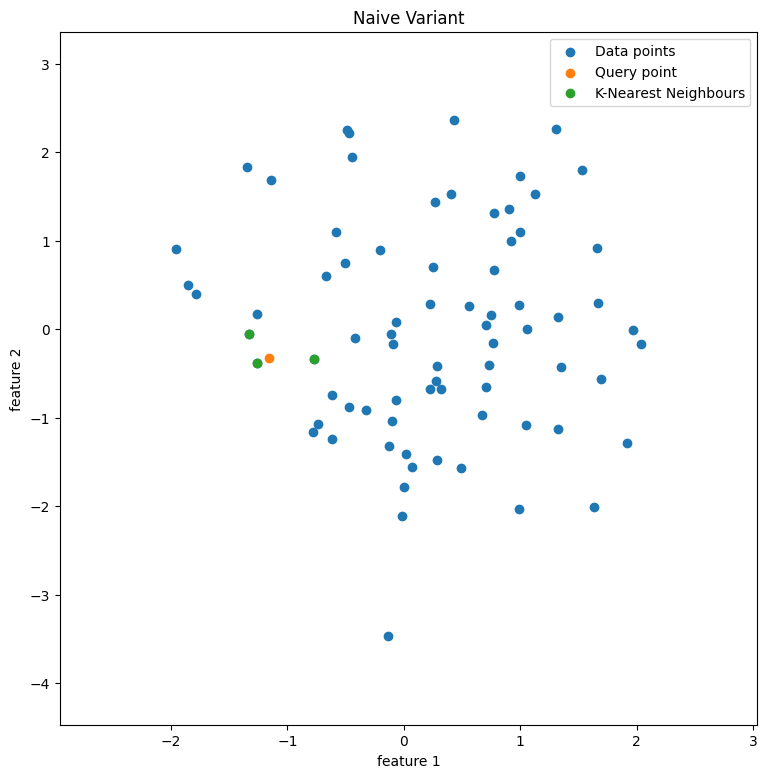

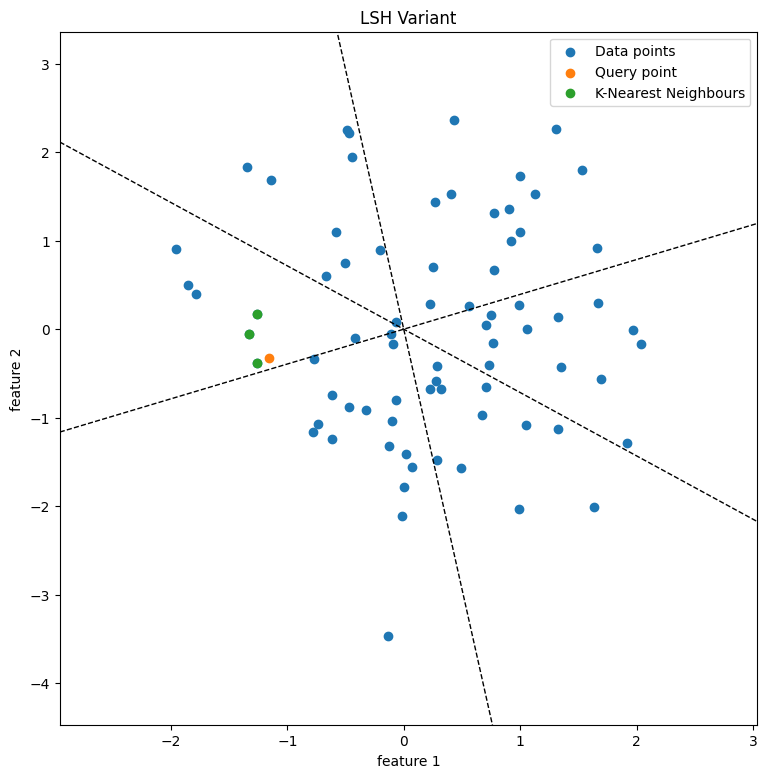

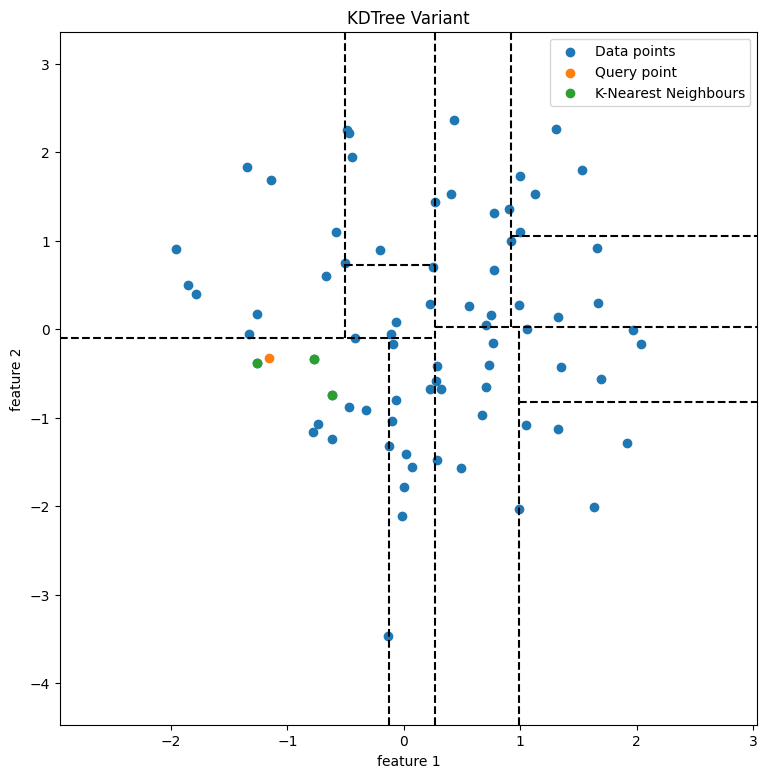

In [35]:
fig=plt.figure(figsize=(9,9))
ax=fig.add_subplot(111)
plot_naive_output(ax,X_train,X_test,nearest_naive)

fig=plt.figure(figsize=(9,9))
ax=fig.add_subplot(111)
plot_lsh_output(ax,X_train,X_test,nearest_lsh,lsh_variant.hashingvectors)

fig=plt.figure(figsize=(9,9))
ax=fig.add_subplot(111)
plot_kdtree_output(ax,X_train,X_test,nearest_kdtree,kdtree_variant.root)

In [41]:
count_kdtree=0
count_lsh=0
for i in nearest_naive:
    if i not in nearest_kdtree:
        count_kdtree=count_kdtree+1
    if i not in nearest_lsh:
        count_lsh=count_lsh+1

print(f'KDTree variant misses out {count_kdtree} k-nearest neighbours.')
print(f'LSH variant misses out {count_lsh} k-nearest neighbours.')

KDTree variant misses out 1 k-nearest neighbours.
LSH variant misses out 1 k-nearest neighbours.
